# Ensemble of Selection Functions

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import fitsio as ft
from glob import glob
from scipy.stats import binned_statistic
import corner
# from getdist import plots, MCSamples

import sys
sys.path.append('/users/PHS0336/medirz90/github/LSSutils')
sys.path.append('/users/PHS0336/medirz90/github/sysnetdev')

from lssutils.dataviz import setup_color, mollview, mycolor
from lssutils.stats.nnbar import get_meandensity, hist
from lssutils.stats.cl import get_cl
import lssutils.utils as ut
from lssutils.lab import AnaFast

from sysnet.sources import init_loss, init_model
from sysnet.sources.io import load_checkpoint, ImagingData, MyDataSet

In [9]:
%matplotlib inline

In [10]:
setup_color()

## Feature Selection for DESI ELG DR9

In [3]:
from lssutils.stats.pcc import pcc

In [17]:
from lssutils.utils import maps_dr9

In [29]:
import sysnet.sources as src

In [4]:
dt = ft.read('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_bmzls_1024.fits')

In [15]:
cc = pcc(dt['features'], dt['label'], kind='spearman', return_err=True)

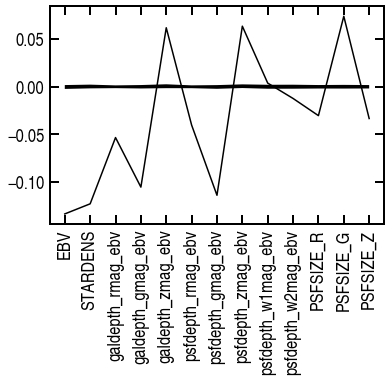

In [20]:
xt = np.arange(len(maps_dr9))


plt.plot(cc[0])
plt.fill_between(xt, *np.percentile(cc[1], [0, 100], axis=0))

_= plt.xticks(xt, labels=maps_dr9, rotation=90)

In [21]:
corrm = np.corrcoef(dt['features'], rowvar=False)

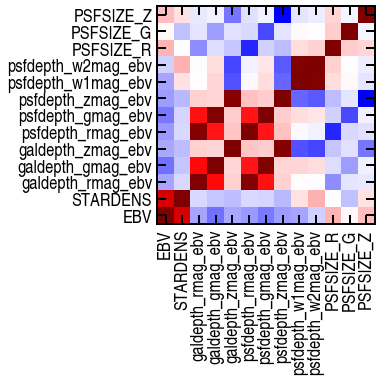

In [26]:
plt.imshow(corrm, origin='lower', vmin=-1, vmax=1.0, cmap='seismic')
plt.yticks(xt, maps_dr9)
_ = plt.xticks(xt, maps_dr9, rotation=90)

In [31]:
model = src.LinearRegression(add_bias=True)

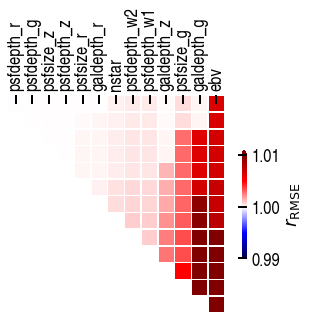

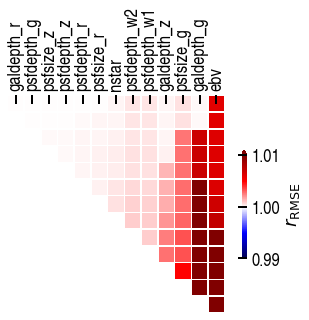

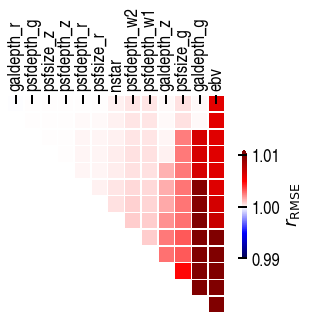

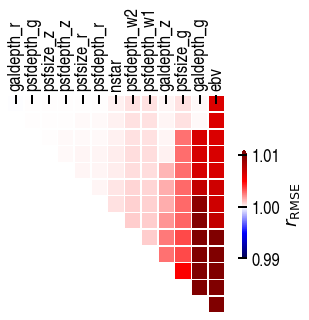

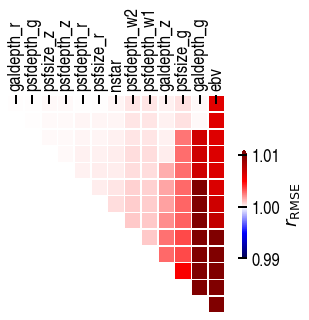

In [32]:
dl = src.MyDataLoader('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_bmzls_1024.fits', 
                      do_kfold=True, seed=4200)

for i in range(5):
    
    fs = src.FeatureElimination(model, dl.load_data(-1, i))
    fs.run([j for j in range(13)])

    maps_dr9 = ['ebv', 'nstar']\
                + [f'galdepth_{b}' for b in ['r', 'g', 'z']]\
                + [f'psfdepth_{b}' for b in ['r', 'g', 'z', 'w1', 'w2']] \
                + [f'psfsize_{b}' for b in ['r', 'g', 'z']]

    fs.plot(labels=maps_dr9, cmap='seismic', vmin=0.99, vmax=1.01)

In [14]:
np.percentile(cc[1], [0, 100], axis=0)

array([[-0.00219182, -0.00213417, -0.00159139, -0.00189115, -0.00234959,
        -0.00158176, -0.00221845, -0.00221919, -0.00206963, -0.00199718,
        -0.00171004, -0.00189476, -0.00171146],
       [ 0.00199508,  0.00222681,  0.00157321,  0.00187049,  0.00222902,
         0.00162367,  0.00181897,  0.00236214,  0.00207354,  0.00213213,
         0.00197478,  0.00233367,  0.00196767]])

In [3]:
PNLL, kw_loss = init_loss('pnll')
DNNP = init_model('dnnp')
DNNP, PNLL

(sysnet.sources.models.DNNPoisson, torch.nn.modules.loss.PoissonNLLLoss)

In [4]:
chcks = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/bmzls_1024/model_*/snapshot_*')
print(len(chcks))

# import torch
# min_val = 1.0e6
# val_loss = []
# best_ch = None
# best_name = None

# for ch in chcks:
#     dch = torch.load(ch)
    
#     bvl = dch['best_val_loss']
#     if bvl < min_val:
#         min_val = bvl
#         best_ch = dch
#         best_name = ch

1000


In [5]:
model = DNNP(4, 20, input_dim=11)
best_ch = load_checkpoint('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/bmzls_1024/model_2_2285845164/snapshot_169.pth.tar', model)

In [6]:
axes = [0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12]
axes

[0, 1, 2, 3, 4, 5, 6, 7, 10, 11, 12]

In [8]:
def load_data(fitsfile, stats, axes):
    templates = ft.read(fitsfile)
    img_data = ImagingData(templates, stats, axes=axes)        
    return MyDataSet(img_data.x, img_data.y, img_data.p, img_data.w)

In [9]:
dl = load_data('/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_bmzls_1024.fits', 
               best_ch['stats'], axes)

In [15]:
from torch.autograd.functional import hessian

In [52]:
pnll = PNLL(**kw_loss)
model.eval()

inputs = dl.x[:2]
observed = dl.y[:2]
fpix = dl.w[:2]

def my_pnll(inputs):
    y = model(inputs)
    loss_ = pnll(y*fpix, observed)
    loss_ = loss_*fpix
    return loss_.sum()

In [37]:
import torch

In [53]:
hess = hessian(my_pnll, inputs)

In [66]:
def pow_adder_reducer(x1, x2): # https://pytorch.org/docs/stable/generated/torch.autograd.functional.hessian.html
    return (2 * x1.pow(2) + 3 * x2.pow(2) + x2.pow(3)).sum()

inputs = (torch.Tensor([1., 1., 1.]), torch.Tensor([1., 2., 3.]))
hessian(pow_adder_reducer, inputs)

((tensor([[4., 0., 0.],
          [0., 4., 0.],
          [0., 0., 4.]]),
  tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]])),
 (tensor([[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]),
  tensor([[12.,  0.,  0.],
          [ 0., 18.,  0.],
          [ 0.,  0., 24.]])))

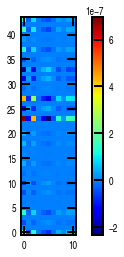

In [55]:
plt.imshow(hess.flatten().reshape(-1, 11), origin='lower', cmap='jet')
plt.colorbar()

In [31]:
hess

tensor([[[[ 6.8849e-04, -2.4714e-03, -1.1571e-03,  ..., -2.4358e-03,
            7.7143e-03, -4.5233e-03],
          [ 6.8635e-04, -1.2519e-03,  1.4255e-03,  ...,  6.3791e-04,
           -4.6962e-04,  1.4836e-03],
          [ 6.8128e-04, -1.3009e-03,  1.4490e-03,  ...,  6.2471e-04,
           -4.4322e-04,  1.5141e-03],
          ...,
          [ 4.9923e-04,  9.0760e-04,  4.0069e-04,  ..., -1.6027e-03,
           -9.4980e-04, -8.4215e-04],
          [ 6.8515e-04, -7.8491e-04,  1.0604e-03,  ...,  2.3639e-04,
           -2.2571e-04,  7.3965e-04],
          [ 7.8901e-04,  2.5246e-04,  4.6629e-04,  ...,  3.5440e-04,
           -6.2980e-04,  4.5393e-04]],

         [[-2.4714e-03,  6.2579e-03, -6.1544e-03,  ...,  2.8408e-04,
           -6.4122e-04, -5.4241e-03],
          [-1.2184e-03,  3.0874e-03, -2.9308e-03,  ..., -1.5850e-03,
            5.8466e-04, -3.2558e-03],
          [-1.2123e-03,  3.2085e-03, -3.0030e-03,  ..., -1.5466e-03,
            5.4310e-04, -3.3441e-03],
          ...,
     

## Extreme Window

In [4]:
windows = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_*')
len(windows)

1000

In [13]:
ds = []
for wind in windows[:10]:
    d_ = hp.read_map(wind, verbose=False, dtype=np.float32)

    mask = d_!=hp.UNSEEN
    d_ = d_ / np.mean(mask)
    d_c = d_.clip(0.1, 10)
    
    dh = hp.ma(d_)
    dhc = hp.ma(d_c)
    
    dh.mask = np.logical_not(mask)
    dhc.mask = np.logical_not(mask)
    
    m_ = hp.anafast(dh.filled(), lmax=1024)
    mc_ = hp.anafast(dhc.filled(), lmax=1024)    
    ds.append([m_, mc_])
#     plt.loglog(m_)
    print('.', end='')

..........

In [23]:
ds = np.array(ds)

In [24]:
np.shape(ds)

(10, 2, 1025)

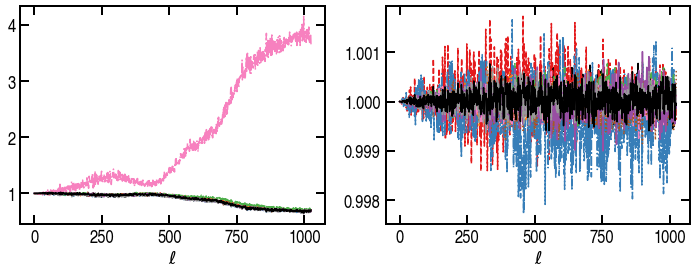

In [30]:
fg, ax = plt.subplots(ncols=2, figsize=(12, 4))

dsm = np.mean(ds, axis=0)

for i in range(10):
    dsi = ds[i]
    for j, dsj in enumerate(dsi):
        ax[j].plot(dsj/dsm[j, :])

for a in ax:a.set(xlabel=r'$\ell$')

## MCMC linear 

In [5]:
class Chains:
    
    def __init__(self, filename, plot=False):
    
        chains_ = np.load(filename, allow_pickle=True)
        self.chains = chains_['chain']
        self.stats = {'x':chains_['x']}#, 'y':chains_['y']}
        print(self.chains.shape)
        self.ndim = self.chains.shape[-1]

        if plot:
            fg, ax = plt.subplots(nrows=self.ndim, figsize=(8, self.ndim*1), sharex=True)#, sharey=True)
            ax = ax.flatten()
            #ax[0].set_ylim(-.5, .5)

            for i, ix in enumerate(range(self.ndim)): #[0, 1, 2, 3, 5]):
                for j in range(400):
                    ax[i].plot(self.chains[:, j, ix])

                ax[i].axhline(0.0, ls=':')    
            fg.show()
        
    def get_sample(self, skip_rows=400):
        return self.chains[skip_rows:, :, :].reshape(-1, self.ndim)

(1000, 400, 12)
(1000, 400, 12)
(1000, 400, 12)


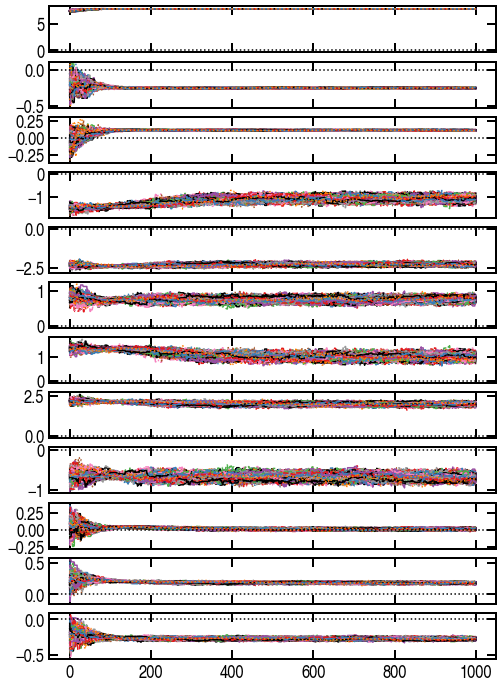

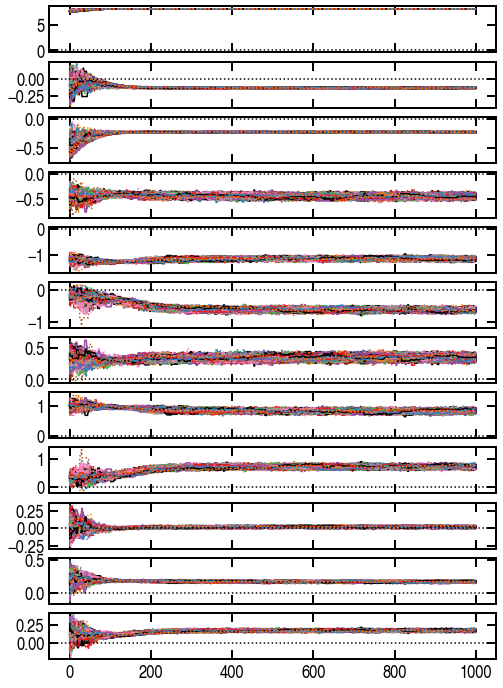

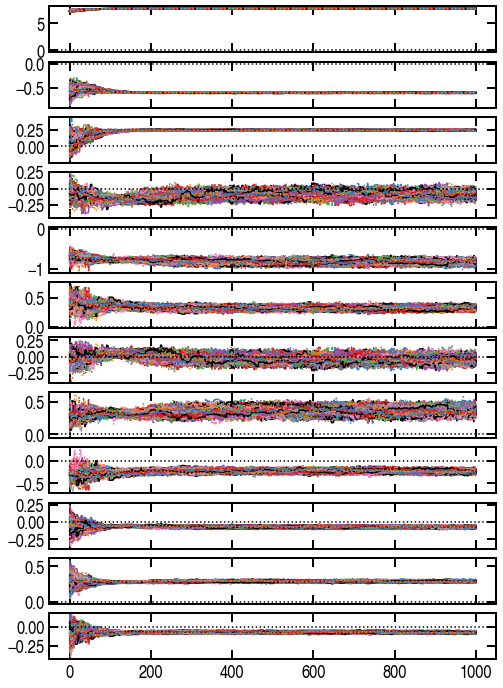

In [6]:
ch1 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/mcmc_sdecals_1024.npz', True)
ch2 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/mcmc_ndecals_1024.npz', True)
ch3 = Chains('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/mcmc_bmzls_1024.npz', True)

In [7]:
s1 = ch1.get_sample(skip_rows=400)
s2 = ch2.get_sample(skip_rows=400)
s3 = ch3.get_sample(skip_rows=400)

In [8]:
columns = np.array(['c', 'EBV', 'star']\
          + [f'galdepth-{b}' for b in ['r', 'g', 'z']]\
          + [f'psfdepth-{b}' for b in ['r', 'g', 'z']]\
          + [f'psfsize-{b}' for b in ['r', 'g', 'z']]) # 
len(columns)

12

In [9]:
ix = [0, 1, 4, 9]

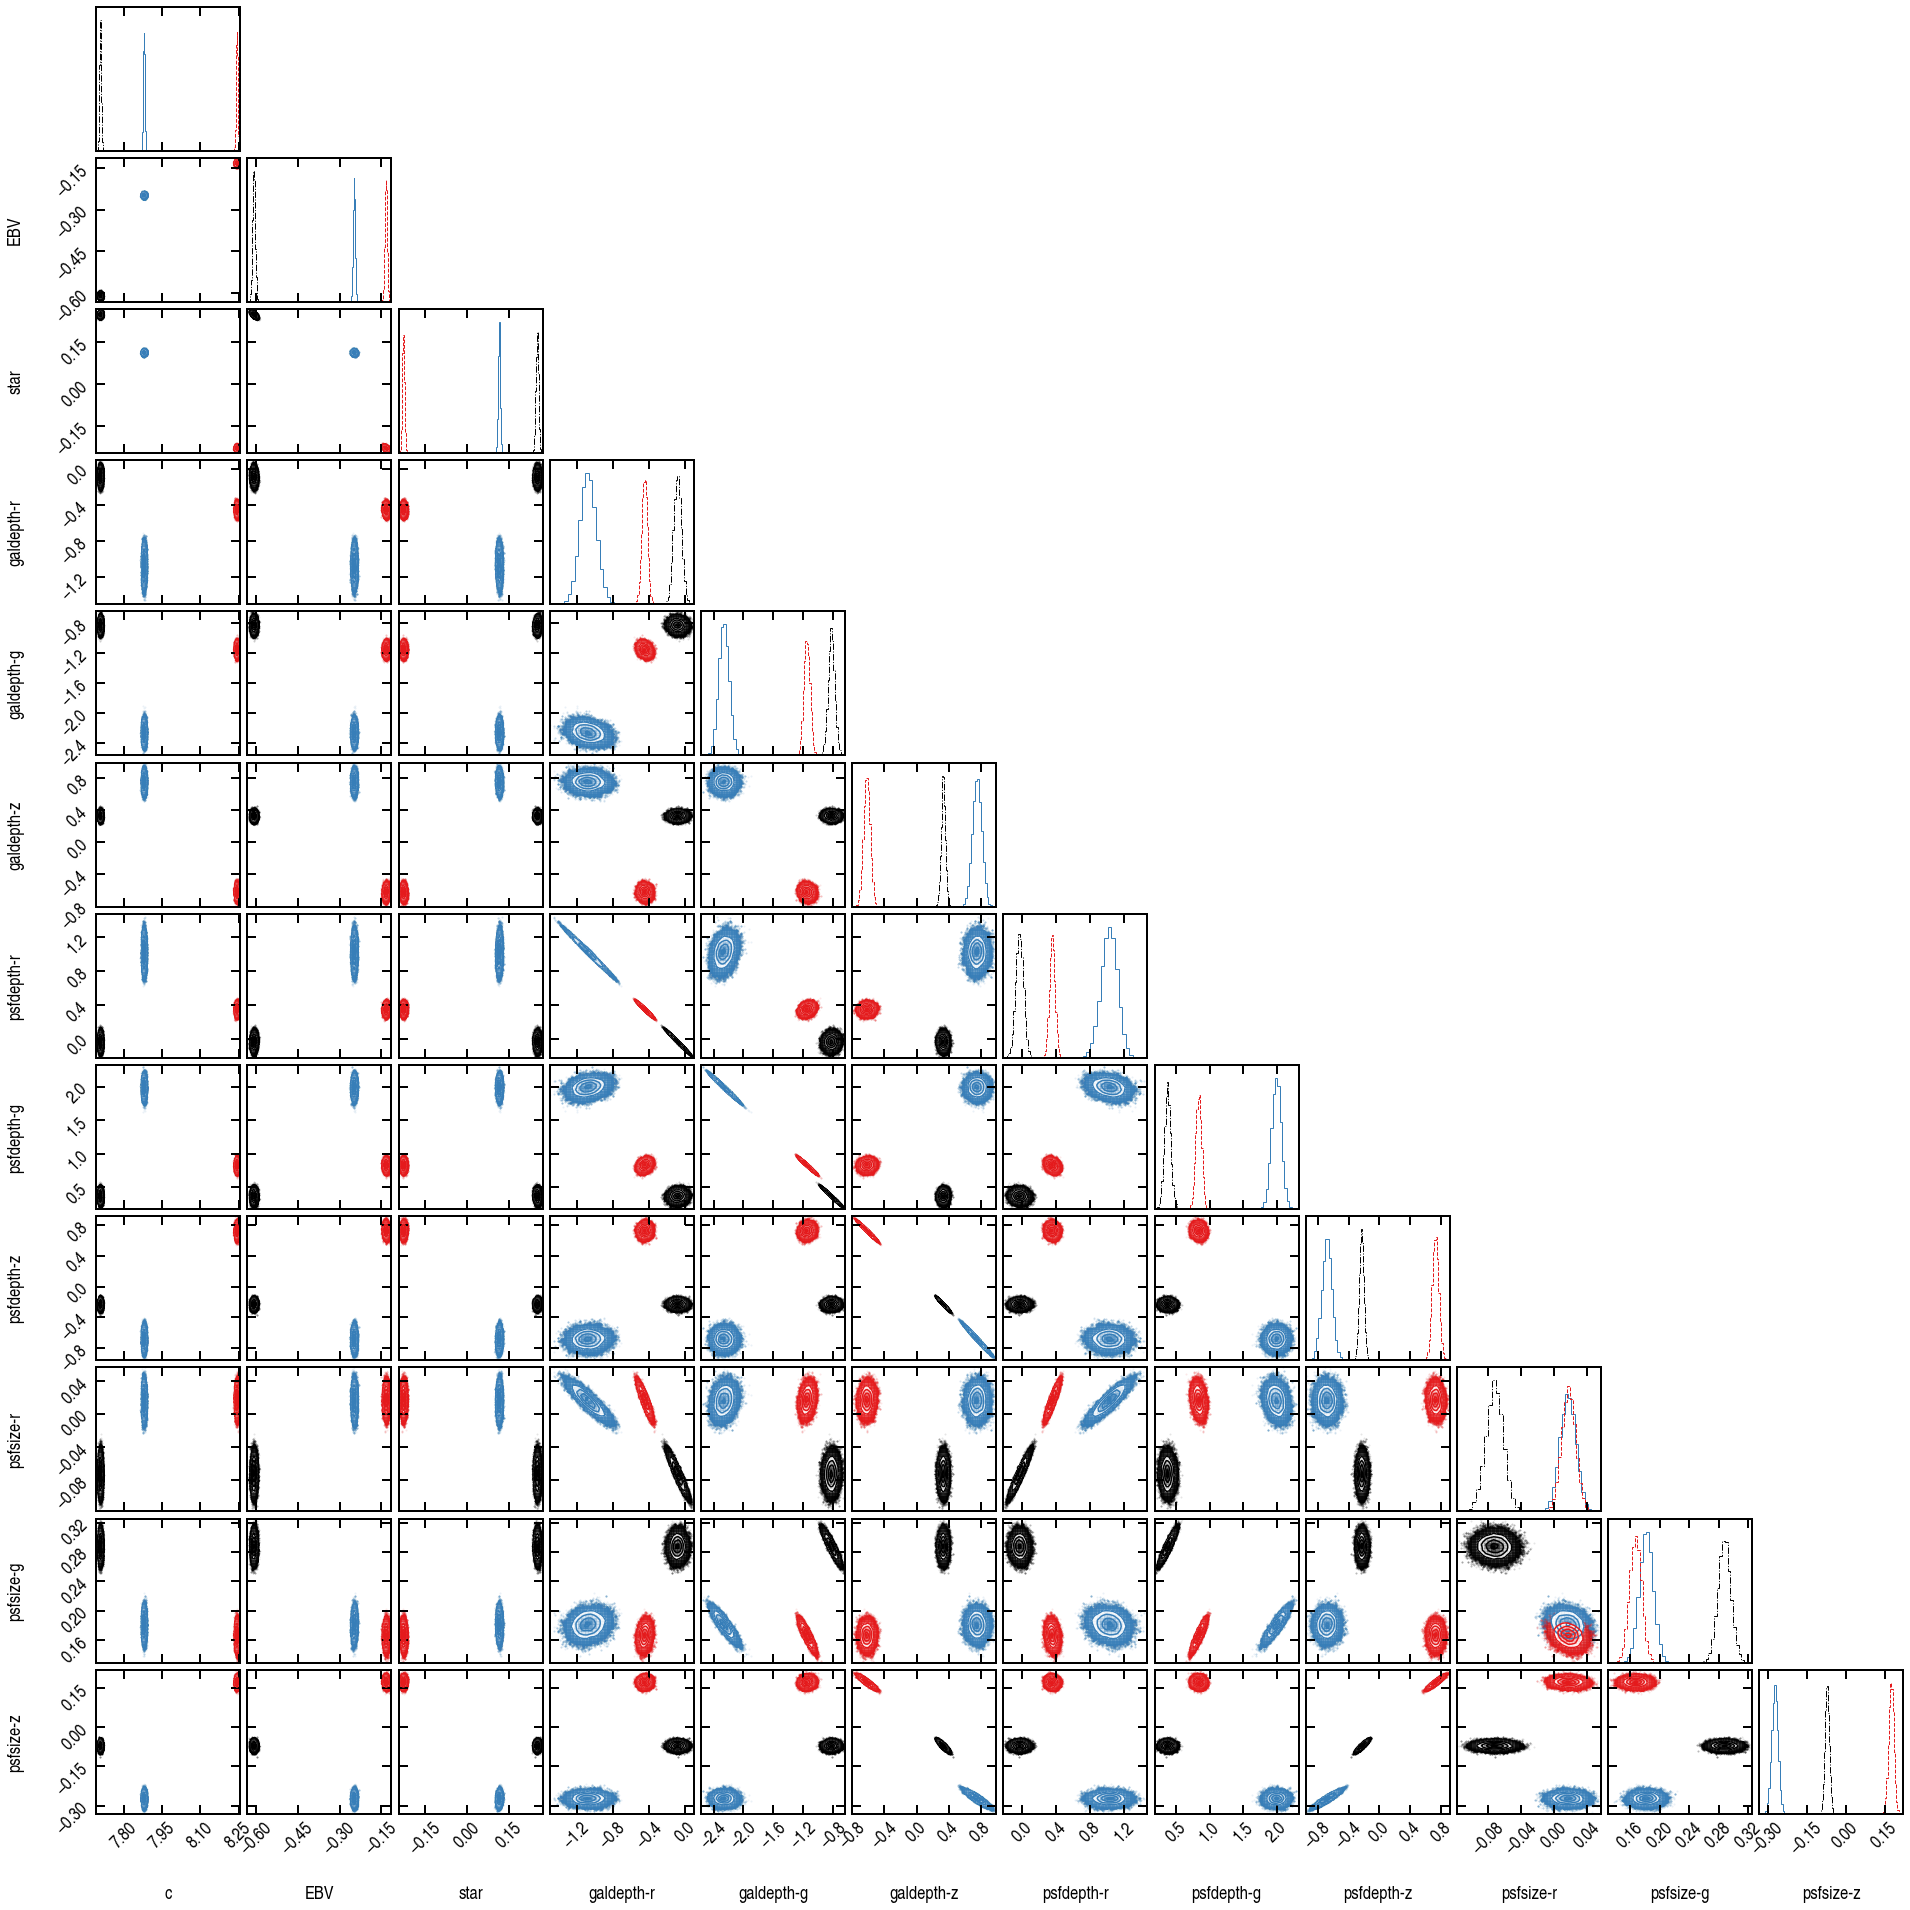

In [10]:
fg = corner.corner(s1, labels=columns, color='C2', group='sdecals')
corner.corner(s2, labels=columns, color='C1', fig=fg, group='ndecals')
corner.corner(s3, labels=columns, color='C0', fig=fg, group='bmzls', labelpad=0.2)
# fg.legend()
fg.align_labels()
plt.show()

'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


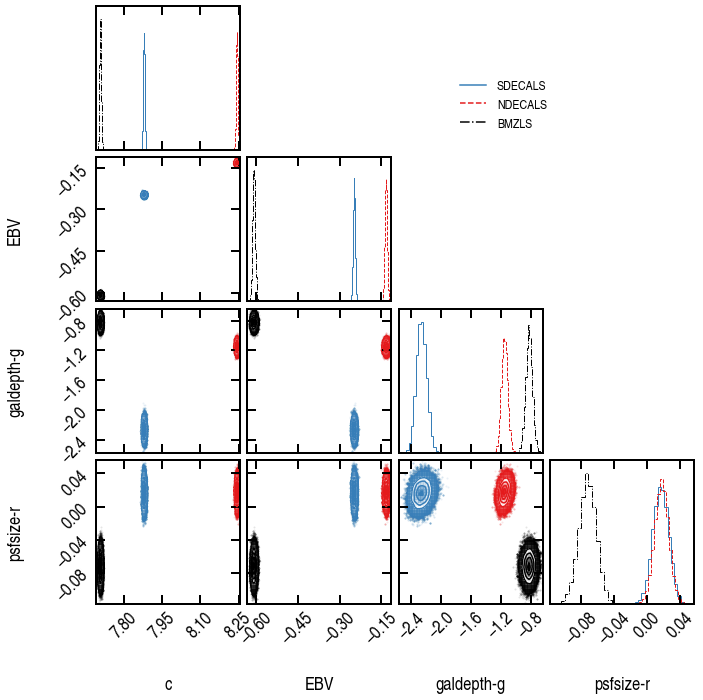

In [12]:
l1 = mlines.Line2D([], [], color='C2', label='SDECALS', ls='-')
l2 = mlines.Line2D([], [], color='C1', label='NDECALS', ls='--')
l3 = mlines.Line2D([], [], color='C0', label='BMZLS', ls='-.')


ix = [0, 1, 4, 9]
fg = corner.corner(s1[:, ix], labels=columns[ix], color='C2', group='sdecals')
corner.corner(s2[:, ix], labels=columns[ix], color='C1', fig=fg, group='ndecals')
corner.corner(s3[:, ix], labels=columns[ix], color='C0', fig=fg, group='bmzls', labelpad=0.2)

fg.legend(handles=[l1, l2, l3], bbox_to_anchor=(0., 0.8, 0.8, .0), loc=4)
fg.align_labels()
fg.savefig('mcmc.pdf', bbox_inches='tight')

## Fpix

In [3]:
regions = ['bmzls', 'ndecals', 'sdecals']
fpix = {}
for region in regions:
    df_ = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{region}_1024.fits')
    fpix[region] = ut.make_hp(1024, df_['hpix'], df_['fracgood'])

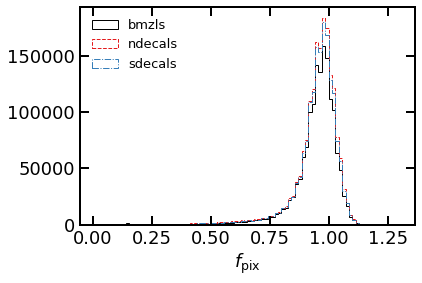

In [27]:
for region in regions:
    plt.hist(fpix[region], label=region, bins=90, histtype='step', range=(0.01, 1.3))
plt.xlabel(r'$f_{\rm pix}$')
plt.legend(loc=2)
# plt.yscale('log')
# plt.ylim()

In [30]:
fpix_map = np.zeros(12*1024*1024)

for region in regions:
    fpix_map += fpix[region]

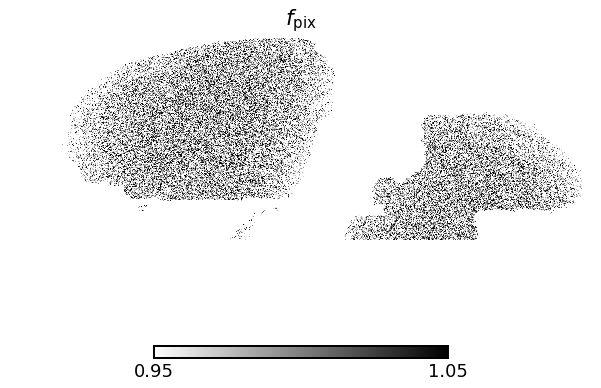

In [41]:
hp.mollview(fpix_map, rot=120, min=0.95, max=1.05, cmap=plt.cm.binary, title=r'$f_{\rm pix}$')

In [42]:
hp.write_map('fpix_map.hp1024.fits', fpix_map, fits_IDL=False, dtype=np.float64)

In [43]:
!gzip fpix_map.hp1024.fits

In [44]:
ls

cl_sg_green_sfd.npz                     LinEnsemble-weighted.ipynb
cl_sg_lenz_green_sfd.npz                logHIvsHI.ipynb
clustering_elg1024dr9.ipynb             meanden_ebv_windows.pdf
clustering_sepvsfull.ipynb              nn_windows.pdf
cross_correlation_nonlinear-1024.ipynb  power_templates.ipynb
cross_correlation_nonlinear.ipynb       pscell_dr9elg.pdf
Ensemble.ipynb                          pscell_windows.pdf
EnsembleWindows.ipynb                   selection_functions.ipynb
fpix_map.hp1024.fits.gz                 split_test.ipynb
GaussianMocks.ipynb                     TestCoordinatesNside.ipynb
LinEnsemble.ipynb                       Window_Vs_Mask.ipynb


## Windows

In [62]:
ws0 = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nn*.fits')
ws0 = np.random.permutation(ws0)
len(ws0), ws0[:5]

(1000,
 array(['/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_294.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_627.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_899.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_749.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnnp/windows/nnwindow_713.hp1024.fits'],
       dtype='<U77'))

In [63]:
ws1 = glob('/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/lin*.fits')
ws1 = np.random.permutation(ws1)
len(ws1), ws1[:5]

(1000,
 array(['/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_476.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_479.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_901.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_332.hp1024.fits',
        '/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linearp/windows/linwindow_483.hp1024.fits'],
       dtype='<U81'))

In [66]:
d0 = []
d1 = []
kw = dict(verbose=False, dtype=np.float32)

for i in range(10):

    d0.append(hp.read_map(ws0[i], **kw))
    d1.append(hp.read_map(ws1[i], **kw))
    
    print('.', end='')

..........

## Mollweide window

<ipython-input-68-4a7c8385747a>:25: RuntimeWarning: invalid value encountered in subtract
  image2 = mollview(d_i-d_i1, -1, 1, '', figax=[fig, ax_i3], cmap=plt.cm.bwr)
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


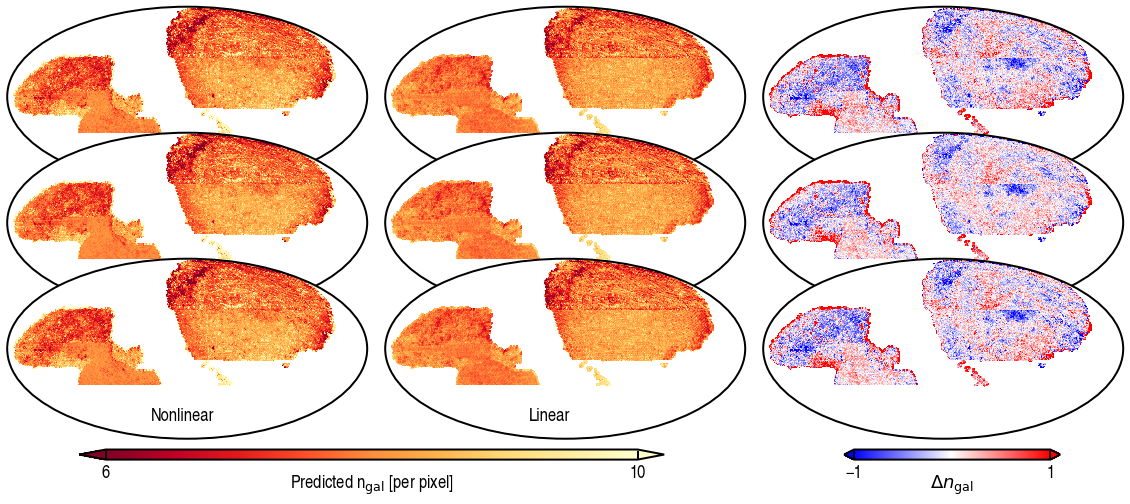

In [68]:
fig = plt.figure(figsize=(5, 7))
ax0  = fig.add_axes([0, 0, 1., 1],       projection='mollweide')
ax1  = fig.add_axes([0., -0.25, 1., 1], projection='mollweide')
ax2  = fig.add_axes([0., -0.50, 1., 1], projection='mollweide')

ax3  = fig.add_axes([1.05, 0, 1., 1],       projection='mollweide')
ax4  = fig.add_axes([1.05, -0.25, 1., 1], projection='mollweide')
ax5  = fig.add_axes([1.05, -0.50, 1., 1], projection='mollweide')

ax6  = fig.add_axes([2.1, 0, 1., 1],       projection='mollweide')
ax7  = fig.add_axes([2.1, -0.25, 1., 1], projection='mollweide')
ax8  = fig.add_axes([2.1, -0.50, 1., 1], projection='mollweide')

for i, (ax_i1, ax_i2, ax_i3) in enumerate(zip([ax0, ax1, ax2], 
                                              [ax3, ax4, ax5],
                                              [ax6, ax7, ax8])):
    d_i = d0[i]*1.0
    d_i[d_i==hp.UNSEEN] = np.inf
    image0 = mollview(d_i, 6, 10, '', figax=[fig, ax_i1], cmap=plt.cm.YlOrRd_r)

    d_i1 = d1[i]*1.0
    d_i1[d_i1==hp.UNSEEN] = np.inf
    image1 = mollview(d_i1, 6, 10, '', figax=[fig, ax_i2], cmap=plt.cm.YlOrRd_r)
    
    image2 = mollview(d_i-d_i1, -1, 1, '', figax=[fig, ax_i3], cmap=plt.cm.bwr)
    
    ax_i1.set(xticks=[], yticks=[])
    ax_i2.set(xticks=[], yticks=[])
    ax_i3.set(xticks=[], yticks=[])
    
    
    
cax = plt.axes([0.2, -0.22, 1.625, 0.02])  # horizontal
cb  = fig.colorbar(image0, cax=cax, label=r'Predicted n$_{{\rm gal}}$ [per pixel]', fraction=0.15,
                   shrink=0.6, ticks=[6, 10],
                   orientation='horizontal', extend='both')        
cb.ax.xaxis.labelpad = -8
cb.solids.set_edgecolor("face")


cax = plt.axes([2.325, -0.22, 0.6, 0.02])  # horizontal
cb  = fig.colorbar(image2, cax=cax, label=r'$\Delta n_{{\rm gal}}$', fraction=0.15,
                   shrink=0.6, ticks=[-1, 1],
                   orientation='horizontal', extend='both')        
cb.ax.xaxis.labelpad = -8
cb.solids.set_edgecolor("face")


ax2.text(0.4, 0.1, 'Nonlinear', transform=ax2.transAxes)
ax5.text(0.4, 0.1, 'Linear', transform=ax5.transAxes)

fig.savefig('nn_windows.pdf', bbox_inches='tight')

## Mean Density

In [69]:
regions = ['bmzls', 'ndecals', 'sdecals']
df = {}

for region in regions:
    df[region] = ft.read(f'/fs/ess/PHS0336/data/rongpu/imaging_sys/tables/v3/nelg_features_{region}_1024.fits')

In [70]:
ng_data = {}

for region in regions:
    ng_ = ut.make_hp(1024, df[region]['hpix'], df[region]['label'])
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5
    st_ = ut.make_hp(1024, df[region]['hpix'], df[region]['features'][:, 0])[:, np.newaxis]
    
    ng_data[region] = get_meandensity(ng_, fr_, ms_, st_, njack=20)
    print(region)

bmzls
ndecals
sdecals


In [73]:
ng_wind0 = {}
ng_wind1 = {}

for region in regions:
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5
    st_ = ut.make_hp(1024, df[region]['hpix'], df[region]['features'][:, 0])#[:, np.newaxis]

    ng_wind = []
    for d_i in d0:
        d_ij = d_i*1.0
        d_ij = d_ij / np.median(d_ij[ms_])
        d_ij = d_ij.clip(0.5, 2.0)
        ng_wind.append(hist((d_ij*fr_)[ms_], fr_[ms_], st_[ms_], bins=ng_data[region][0]['bin_edges']))
        print('.', end='')
    ng_wind0[region] = ng_wind
    print('')
    
    ng_wind = []
    for d_i in d1:
        d_ij = d_i*1.0
        d_ij = d_ij / np.median(d_ij[ms_])
        d_ij = d_ij.clip(0.5, 2.0)
        ng_wind.append(hist((d_ij*fr_)[ms_], fr_[ms_], st_[ms_], bins=ng_data[region][0]['bin_edges']))
        print('.', end='')
        
    ng_wind1[region] = ng_wind       
    print(region)

..........
..........bmzls
..........
..........ndecals
..........
..........sdecals


'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


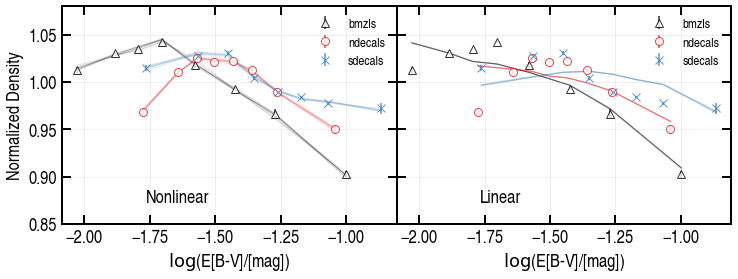

In [76]:
def add_plot(ax, ng_data, nb_winds, text=''):
    
    mk = ['^', 'o', 'x']

    i = 0
    for n_i, ng_i in ng_data.items():
        ln = ax.errorbar(np.log10(ng_i[0]['bin_avg']), ng_i[0]['nnbar'], yerr=ng_i[0]['nnbar_err'], 
                         marker=mk[i], markersize=8, mfc='w', alpha=0.8, ls='None', label=n_i)
        i += 1
        for ng_j in nb_winds[n_i]:
            ax.plot(np.log10(ng_j[0]), ng_j[1], color=ln[0].get_color(), 
                    ls='-', lw=1, alpha=0.1, zorder=-10)

    ax.set(xlabel=r'$\log$(E[B-V]/[mag])') # ylim=(0.89, 1.05), 
    ax.legend()
    ax.grid(lw=1, alpha=0.2)
    ax.text(0.25, 0.1, text, transform=ax.transAxes)
    

    
fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, sharex=True)
fg.subplots_adjust(wspace=0.0)


add_plot(ax[0], ng_data, ng_wind0, 'Nonlinear')
add_plot(ax[1], ng_data, ng_wind1, 'Linear')
ax[0].set_ylabel('Normalized Density')
ax[0].set_ylim(0.85, 1.08)

fg.savefig('meanden_ebv_windows.pdf', bbox_inches='tight')

## Angular Power

In [82]:
cl_data = {}

for region in regions:
    ng_ = ut.make_hp(1024, df[region]['hpix'], df[region]['label'])
    fr_ = ut.make_hp(1024, df[region]['hpix'], df[region]['fracgood'])
    ms_ = ut.make_hp(1024, df[region]['hpix'], 1.0) > 0.5
    
    cl_data[region] = get_cl(ng_, fr_, ms_, njack=0)
    print(region)

bmzls
ndecals
sdecals


'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


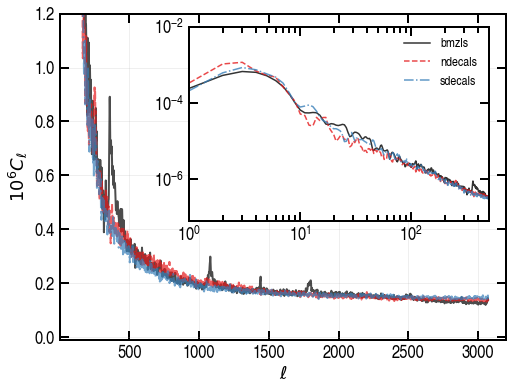

In [83]:
fg, ax = plt.subplots(figsize=(8, 6))
ax1 = fg.add_axes([0.35, 0.4, 0.52, 0.45])


for n, cl_i in cl_data.items():
    ax.plot(1.0e6*cl_i['cl_gg']['cl'], alpha=0.7, label=n, lw=2)
    ax1.plot(cl_i['cl_gg']['cl'], alpha=0.8, label=n)

    
ax1.legend(loc='upper right')
ax.grid(lw=1, alpha=0.2, which='both')
ax1.set(xlim=(1., 500.), ylim=(8.0e-8, 1.0e-2), xscale='log', yscale='log')
ax.set(xlim=(1, 3200), ylim=(-1.0e-2, 1.2), ylabel=r'$10^{6}C_{\ell}$', xlabel=r'$\ell$')

fg.savefig('cl_dr9elg.pdf', bbox_inches='tight')

In [78]:
def loadcl(filename):
    c_ = np.load(filename, allow_pickle=True)
    return np.concatenate(c_.flatten())

cl_wlin = {}
for reg in ['bmzls', 'ndecals', 'sdecals']:
    cl_wlin[reg] = loadcl(f'/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_linear/windows/cell_{reg}.npy')

In [79]:
cl_wnn = {}
for reg in ['bmzls', 'ndecals', 'sdecals']:
    cl_wnn[reg] = loadcl(f'/fs/ess/PHS0336/data/tanveer/dr9/v3/elg_dnn/windows/cell_{reg}.npy')

In [80]:
from matplotlib.gridspec import GridSpec

'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.
'NimbusSansNarrow-Regular.otf' can not be subsetted into a Type 3 font. The entire font will be embedded in the output.


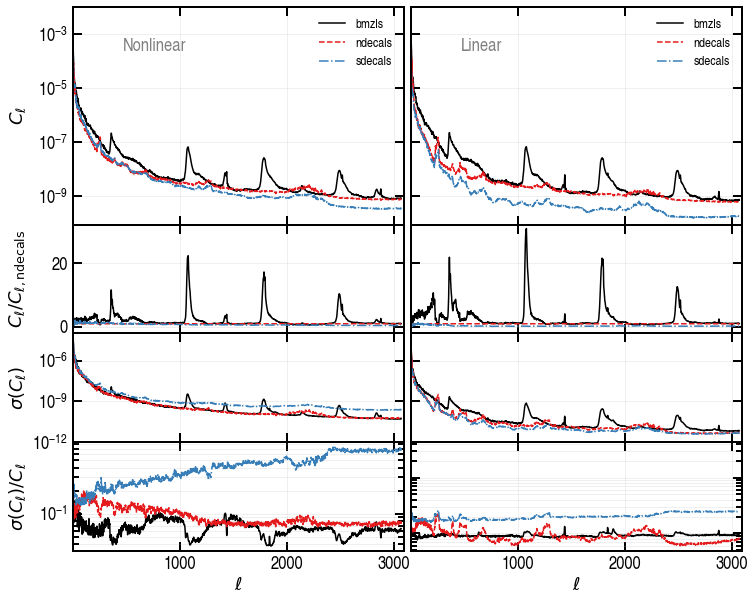

In [81]:
def add_plot(ax1, ax3, ax5, ax7, nb_winds, text=''):
    
    mk = ['^', 'o', 's']
    colors = ['C0', 'C1', 'C2']
    cl_ndec = np.mean(nb_winds['ndecals'], axis=0)
    
    for i, n_i in enumerate(['bmzls','ndecals', 'sdecals']):
        
        cl_mean = np.mean(nb_winds[n_i], axis=0)
        cl_std  = np.std(nb_winds[n_i], axis=0)
        #for ng_j in nb_winds[n_i]:    
        #    ax.plot(ng_j, color=colors[i], 
        #            ls='-', lw=1, alpha=0.1, zorder=-10)
            
        ax1.plot(cl_mean, color=colors[i], label=n_i)
        ax3.plot(cl_mean/cl_ndec, color=colors[i])
        ax5.plot(cl_std, color=colors[i])
        ax7.plot(cl_std/cl_mean, color=colors[i])
    

    ax1.legend(loc='upper right')
    ax1.set(yscale='log', xlim=(1.0, 3100), ylim=(9.0e-11, 1.0e-2))
    ax3.set(xlim=(1.0, 3100), xlabel=r'$\ell$', ylim=(-2, 32.0))
    #     ax3.set_yscale('symlog', linthresh=10)
    ax5.set(xlim=(1.0, 3100), yscale='log', ylim=(1.0e-12, 1.0e-4))    
    ax7.set(xlabel=r'$\ell$', xlim=(1.0, 3100.), yscale='log')
    
    for ax in [ax1, ax3, ax5, ax7]:
        ax.grid(lw=1, alpha=0.2, which='both')
    ax1.text(0.15, 0.8, text, color='grey', transform=ax1.transAxes)
    

    
#fg, ax = plt.subplots(ncols=2, figsize=(12, 4), sharey=True, sharex=True)
#fg.subplots_adjust(wspace=0.0)
fig = plt.figure(figsize=(12, 10), constrained_layout=False)
gs = GridSpec(5, 2, figure=fig)

ax1 = fig.add_subplot(gs[:2, 0])
ax2 = fig.add_subplot(gs[:2, 1])
ax3 = fig.add_subplot(gs[2, 0])
ax4 = fig.add_subplot(gs[2, 1])
ax5 = fig.add_subplot(gs[3, 0])
ax6 = fig.add_subplot(gs[3, 1])
ax7 = fig.add_subplot(gs[4, 0])
ax8 = fig.add_subplot(gs[4, 1])


for ax in [ax1, ax2, ax3, ax4, ax5, ax6]:
    ax.tick_params(labelbottom=False)
for ax in [ax2, ax4, ax6, ax8]:
    ax.tick_params(labelleft=False)
    

fig.subplots_adjust(hspace=0.0, wspace=0.02)

add_plot(ax1, ax3, ax5, ax7, cl_wnn, 'Nonlinear')
add_plot(ax2, ax4, ax6, ax8, cl_wlin, 'Linear')

ax1.set_ylabel(r'$C_{\ell}$')
ax3.set_ylabel(r'$C_{\ell}/C_{\ell, {\rm ndecals}}$')
ax5.set_ylabel(r'$\sigma(C_{\ell})$')
ax7.set_ylabel(r'$\sigma(C_{\ell})/C_{\ell}$')

fig.align_labels()
fig.savefig('cl_windows.pdf', bbox_inches='tight', dpi=300)

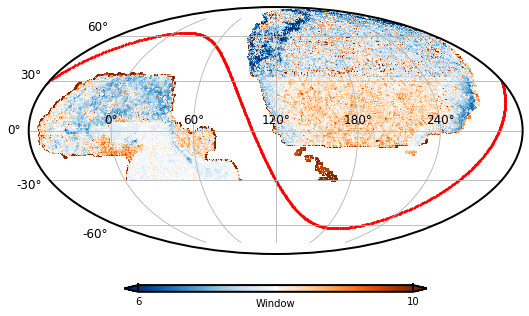

In [17]:
mollview(d, 6, 10, 'Window', galaxy=True, colorbar=True, cmap=mycolor())